In [1]:
import flask
from IPython import display 
import werkzeug
import time
import tensorflow as tf
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import math
import numpy as np
import cv2 
import imageio


import pandas as pd
import numpy as np

import seaborn as sns


from matplotlib import colors
import colorsys
import os
import io

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on all addresses.
 * Running on http://192.168.57.105:5000/ (Press CTRL+C to quit)



Number of Received Images :  1

Saving Image  1 / 1
MALE,COOL,Residential,Kitchen,orange.jpg


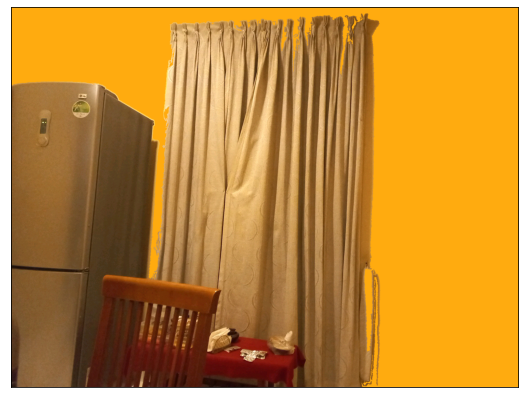

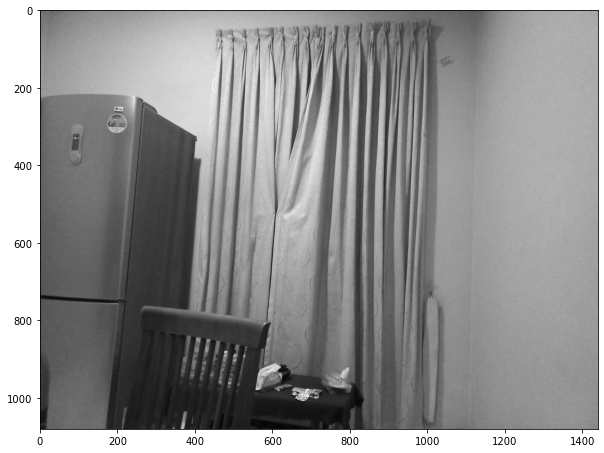

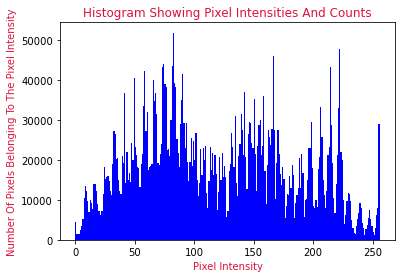

Type of the image :  <class 'imageio.core.util.Array'>

Shape of the image : (1080, 1440)
Image Hight 1080
Image Width 1440
Dimension of Image 2


192.168.57.223 - - [07/May/2022 12:19:07] "POST / HTTP/1.1" 200 -


Luminance:  202
Hello color: Mcrb
Color A: g #008000
Color B: blue #0000ff
Color C: firebrick #b22222
Color D: xkcd:yellowish orange #ffab0f
Color E: blueviolet #8a2be2
g #008000  firebrick #b22222  xkcd:yellowish orange #ffab0f  blueviolet #8a2be2


In [ ]:
from flask import Flask, render_template
from flask import send_file
from os import path, extsep
from IPython.display import display
from PIL import Image
import base64
import firebase_admin
from firebase_admin import credentials
from firebase_admin import storage
from uuid import uuid4

# import request
from flask import request


app = flask.Flask(__name__)

@app.route("/", methods=['GET', 'POST'])


def handle_request():
    files_ids = list(flask.request.files)
    print("\nNumber of Received Images : ", len(files_ids))
    image_num = 1
    for file_id in files_ids:
        print("\nSaving Image ", str(image_num), "/", len(files_ids)) 
        imagefile = flask.request.files[file_id]
        filename = werkzeug.utils.secure_filename(imagefile.filename)
        im=imagefile.filename
        im_edit=im.replace("%0A",",")
        im_edit2=im_edit.replace("0","")
        print(im_edit2)
        #timestr = time.strftime("%Y%m%d-%H%M%S")
        ## display.image(files_ids)
        imagefile.save(im_edit2)
    
        image_num = image_num + 1
        
        
        


        image_path = im_edit2

        image_string=tf.io.read_file(image_path)

        image=tf.image.decode_jpeg(image_string,channels=3)
       
       
        def show_image(original_image,augmented_image,title):
            
            
            fig=plt.figure()
            fig.suptitle(title)
  
            original_plt=fig.add_subplot(1, 1, 1)
  
           
            original_plt.imshow(original_image)

            augmented_plt=fig.add_subplot(1, 1, 1) 
          
            augmented_plt.imshow(augmented_image)
            plt.show(block=True)
       
        
        pic = imageio.imread(im_edit2)
        ################################# WALL PREVIEW applying image segmentation ###################################################
        
        img = pic
        cImg = img.copy()
        img = cv2.blur(img, (5, 5))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        scale = 1
        delta = 0
        ddepth = cv2.CV_16S

        grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
        grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)

        abs_grad_x = cv2.convertScaleAbs(grad_x)
        abs_grad_y = cv2.convertScaleAbs(grad_y)

        grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

        ret, thresh = cv2.threshold(grad, 10, 255, cv2.THRESH_BINARY_INV)

        c, h = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        areas = [cv2.contourArea(c1) for c1 in c]
        maxAreaIndex = areas.index(max(areas))

        cv2.drawContours(cImg, c, maxAreaIndex, (255, 171, 15), -1)
        plt.figure(figsize=(10,7))

        plt.gca().axes.get_xaxis().set_visible(False)
        plt.gca().axes.get_yaxis().set_visible(False)
      

        plt.imshow(cImg)
        plt.show()
        resized_image = cv2.resize(cImg, (540, 360)) 
        # image = cv2.rotate(resized_image, cv2.cv2.ROTATE_90_CLOCKWISE)
        cv2.imwrite('C:/Users/Araliya Alwis/Desktop/Downloads/Image Processing/final_new.jpg',resized_image)
        
        
############################ To send the wall colour applied image to the Google cloud storage as to get image through a URL to the Android Studio #################################
       

        cred = credentials.Certificate("C:/Users/Araliya Alwis/Desktop/Downloads/Image Processing/spotty-69438-fe968315eb1e.json")
        default_app = firebase_admin.initialize_app(cred, {
            'storageBucket': 'spotty-69438.appspot.com'
        })

        bucket = storage.bucket()
        blob = bucket.blob('final_new.jpg')

        # Create new token
        new_token = uuid4()

        # Create new dictionary with the metadata
        metadata  = {"firebaseStorageDownloadTokens": new_token}

        # Set metadata to blob
        blob.metadata = metadata

        # Upload file
        blob.upload_from_filename(filename='final_new.jpg', content_type='image/png')


################################################# Luminance extraction from the captured image #####################################################################
        
        

        gray = lambda rgb : np.dot(rgb[... , :3] , [0.21 , 0.72, 0.07]) 
        gray = gray(pic)  

        plt.figure( figsize = (10,10))
        plt.imshow(gray, cmap = plt.get_cmap(name = 'gray'))
        plt.show()
       
        plt.hist(x=pic.ravel(), bins=256, range=[0, 256], color='Blue')
        plt.title("Histogram Showing Pixel Intensities And Counts", color='crimson')
        plt.ylabel("Number Of Pixels Belonging To The Pixel Intensity", color="crimson")
        plt.xlabel("Pixel Intensity", color="crimson")
        plt.show()
        
        print('Type of the image : ' , type(gray))
        print()
        print('Shape of the image : {}'.format(gray.shape))
        print('Image Hight {}'.format(gray.shape[0]))
        print('Image Width {}'.format(gray.shape[1]))
        print('Dimension of Image {}'.format(gray.ndim))
        
        ############## The below algorithm is used to extract the luminsnce from a defined image resolution and to round off the value to the msot approximate integer ######## 
        sumi=0.0
        sumi_new=float(sumi)
        for i in range(0, 1080):
            
  
            for j in range(0, 1440):
        
      
                #print('Random indexes [X,Y] : {}'.format(gray[i, j]))
                sum_inten=float(format(gray[i, j]))
                sumi_new=int(sumi_new+sum_inten)
                sumi_new_int=int(sumi_new/1000000)
                
             
        
            #print()
            
        print("Luminance: ",sumi_new_int)
        
        im_edit6=im_edit2.replace(".jpg","")
       
        im_edit7=im_edit6.replace(","," ")
        
        
        store = im_edit7
        a, b, c, d,e = store.split()
        
        
                
#--------------------- Color suggestion algorithm starts off  from the below code lines which has initialized values to input data/parameters into the algorithm -------------------------#

        lumi = int(sumi_new_int)
        gender = a
        cTone = b
        buildType = c
        basic_c = e
        output = 'color'
        
        
        for dirname, _, filenames in os.walk('/kaggle/input'):
            for filename in filenames:
                print(os.path.join(dirname, filename))
        
        ###########  read data having the colour data set imported from KAGGLE #################
        df = pd.read_csv(r'C:\Users\Araliya Alwis\Desktop\Downloads\Image Processing\archive\colors_and_palettes.csv')
        df.head()

        
        
        if lumi in range(2,10):
            print("Too dark, please send a clear picture")
        elif lumi in range(350, 1000):
            print("Too bright, please send a clear picture")
            
        ########################## MALE ############################################
        ########################## WARM TONE #######################################
            
        if gender == 'MALE':
            if cTone == 'WARM': 
                if lumi in range (10,50):
                    if buildType == 'Residential':
                        #Warm residential dark 
                        print("Hello color: Mwrd")
 
                        #Function to get colors from dataset 
                        colr = ['xkcd:banana yellow', 'blue', 'xkcd:bright lavender', 'xkcd:bright olive','xkcd:golden yellow']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                       
                        print(res)
                        return res
                    
                    elif buildType == 'CooperateOffices':
                        #Warm CooperateOffices dark 
                        print("Hello color: Mwcd")
                         #Function to get colors from dataset 
                        colr = ['xkcd:light lavender', 'blue', 'xkcd:light mustard', 'xkcd:light peach','xkcd:light turquoise']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
           
                            output =f"{i} {c_hex}"
                            
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'Academics':
                        #Warm academics dark 
                        print("Hello color: Mwad")
                        
                        #Function to get colors from dataset 
                        colr = ['xkcd:pastel yellow', 'blue', 'xkcd:yellow tan', 'xkcd:tiffany blue','xkcd:soft purple']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'HealthCare':
                        #Warm healthcare dark 
                        print("Hello color: Mwhd")
                        
                        #Function to get colors from dataset 
                        colr = ['xkcd:pistachio', 'blue', 'xkcd:pinkish tan', 'xkcd:pastel green','xkcd:pale sky blue']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                elif lumi in range (50,100):
                    if buildType == 'Residential':
                         #Warm residential mild bright 
                        print("Hello color: Mwrmb")
                        
                        #Function to get colors from dataset 
                        colr = ['xkcd:nasty green', 'blue', 'xkcd:muted blue', 'xkcd:muted purple','xkcd:off yellow']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'CooperateOffices':
                        #Warm cooperative mild bright
                        print("Hello color: Mwcmb")
                        
                        #Function to get colors from dataset 
                        colr = ['xkcd:ocean blue', 'blue', 'xkcd:olive yellow', 'xkcd:pale orange',' xkcd:periwinkle']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'Academics':
                          #Warm academic mild bright
                        print("Hello color: Mwamb")
                        
                        #Function to get colors from dataset 
                        colr = ['xkcd:piss yellow', 'blue', 'xkcd:purpleish', 'xkcd:sandy yellow','xkcd:seafoam blue']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'HealthCare':
                        #Warm healthcare mild bright
                        print("Hello color: Mwhmb")
                        
                        #Function to get colors from dataset 
                        colr = ['xkcd:seafoam blue', 'blue', 'xkcd:sickly yellow', 'xkcd:tealish','xkcd:pear']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                elif lumi in range (100,150):
                    if buildType == 'Residential':
                        #Warm residential neutral
                        print("Hello color: Mwrn")
                        #Function to get colors from dataset 
                        colr = ['xkcd:camel', 'blue', 'xkcd:cream', 'xkcd:dark cream','xkcd:dusky rose']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'CooperateOffices':
                         #Warm CooperateOffices neutral
                        print("Hello color: Mwcn")
                        #Function to get colors from dataset 
                        colr = ['xkcd:ecru', 'blue', 'xkcd:egg shell', 'xkcd:grey pink','xkcd:grey teal']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'Academics':
                        #Warm academic neutral
                        print("Hello color: Mwan")
                        
                        #Function to get colors from dataset 
                        colr = ['xkcd:ice', 'blue', 'xkcd:ivory', 'xkcd:jade','xkcd:light mint']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'HealthCare':
                        #Warm healthcare neutral
                        print("Hello color: Mwhn")
                        
                        #Function to get colors from dataset 
                        colr = ['xkcd:pale', 'blue', 'xkcd:pale aqua', 'xkcd:pale lavender ','xkcd:off green']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                elif lumi in range (150,350):
                    if buildType == 'Residential':
                        #Warm residential bright
                        print("Hello color: Mwrb")
                        
                        colr = ['xkcd:midnight purple', 'blue', 'xkcd:midnight blue', 'xkcd:muddy green','xkcd:indigo']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
           
                            output =f"{i} {c_hex}"
            
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                           
                                            
                    elif buildType == 'CooperateOffices':
                         #Warm CooperateOffices bright
                        print("Hello color: Mwcb")
                        
                        #Function to get colors from dataset 
                        colr = ['xkcd:faded green', 'blue', 'xkcd:faded purple', 'xkcd:fern green','xkcd:dusty blue']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'Academics':
                         #Warm acadenic bright
                        print("Hello color: Mwab")
                        #Function to get colors from dataset 
                        colr = ['xkcd:faded green', 'blue', 'xkcd:faded purple', 'xkcd:fern green','xkcd:dusty blue']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'HealthCare':
                         #Warm healthcare bright
                        print("Hello color: Mwhb")
                        
                        #Function to get colors from dataset 
                        colr = ['xkcd:deep turquoise', 'blue', 'xkcd:deep teal', 'xkcd:dirty orange','xkcd:dirty purple']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    
            ################################### COOL TONE ################################    
                    
            elif cTone == 'COOL': 
                if lumi in range(10,50):
                    if buildType == 'Residential':
                         #Cool residential dark
                        print("Hello color: Mcrd")
                        
                        #Function to get colors from dataset 
                        colr = ['xkcd:tea', 'blue', 'xkcd:snot', 'xkcd:soft blue','xkcd:soft purple']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'CooperateOffices':
                         #Cool CooperateOffices dark
                        print("Hello color: Mccd")
                        
                        #Function to get colors from dataset 
                        colr =['xkcd:bluish', 'blue', 'xkcd:brownish yellow', 'xkcd:dark lime green','xkcd:light gold']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'Academics':
                        #Cool academics dark
                        print("Hello color: Mcad")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'HealthCare':
                         #Cool healthcare dark
                        print("Hello color: Mchd")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                elif lumi in range(50,100):
                    if buildType == 'Residential':
                          #Cool residential mild bright 
                        print("Hello color: Mcrmb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'CooperateOffices':
                          #Cool CooperateOffices mild bright 
                        print("Hello color: Mccmb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'Academics':
                          #Cool academics mild bright 
                        print("Hello color: Mcamb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'HealthCare':
                         #Cool healthcare mild bright 
                        print("Hello color: Mchmb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                elif lumi in range(100,150):
                    if buildType == 'Residential':
                          #Cool residential neutral
                        print("Hello color: Mcrn")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'CooperateOffices':
                        #Cool CooperateOffices neutral
                        print("Hello color: Mccn")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'Academics':
                           #Cool academics neutral
                        print("Hello color: Mcan")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'HealthCare':
                        #Cool healthcare neutral
                        print("Hello color: Mchn")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                elif lumi in range(150,350):
                    if buildType == 'Residential':
                        #Cool residential bright
                        print("Hello color: Mcrb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'CooperateOffices':
                            #Cool CooperateOffices bright
                        print("Hello color: Mccb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'Academics':
                        #Cool academics bright
                        print("Hello color: Mcab")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'HealthCare':
                        #Cool healthcare bright
                        print("Hello color: Mchb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
             
            ############################## NEUTRAL TONE #######################################
                    
            elif cTone == 'NEUTRAL': 
                if lumi in range(10,50):
                    if buildType == 'Residential':
                        #Neutral residential dark
                        print("Hello color: Mnrd")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'CooperateOffices':
                        #Neutral CooperateOffices dark
                        print("Hello color: Mncd")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'Academics':
                         #Neutral academics dark
                        print("Hello color: Mnad")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'HealthCare':
                         #Neutral healthcare dark
                        print("Hello color: Mnhd")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                elif lumi in range(50,100):
                    if buildType == 'Residential':
                         #Neutral residential mild bright
                        print("Hello color: Mnrmb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'CooperateOffices':
                         #Neutral CooperateOffices mild bright
                        print("Hello color: Mncmb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'Academics':
                         #Neutral academics mild bright
                        print("Hello color: Mnamb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'HealthCare':
                        #Neutral healthcare mild bright
                        print("Hello color: Mnhmb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                elif lumi in range(100,150):
                    if buildType == 'Residential':
                         #Neutral Residential neutral
                        print("Hello color: Mnrn")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'CooperateOffices':
                         #Neutral CooperateOffices neutral
                        print("Hello color: Mncn")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'Academics':
                         #Neutral Academics neutral
                        print("Hello color: Mnan")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'HealthCare':
                        #Neutral HealthCare neutral
                        print("Hello color: Mnhn")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                elif lumi in range(150,350):
                    if buildType == 'Residential':
                         #Neutral Residential bright
                        print("Hello color: Mnrb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'CooperateOffices':
                        #Neutral CooperateOffices bright
                        print("Hello color: Mncb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'Academics':
                           #Neutral Academics bright
                        print("Hello color: Mnab")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'HealthCare':
                        #Neutral HealthCare bright
                        print("Hello color: Mnhb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    
                    
                    
         ####################### FEMALE ############################################ 
         ####################### WARM TONE ############################################
                        
        if gender == 'FEMALE':
            if cTone == 'WARM': 
                if lumi in range (10,50):
                    if buildType == 'Residential':
                        #Warm residential dark 
                        print("Hello color: Fwrd")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'CooperateOffices':
                        #Warm CooperateOffices dark 
                        print("Hello color: Fwcd")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'Academics':
                        #Warm academics dark 
                        print("Hello color: Fwad")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'HealthCare':
                        #Warm healthcare dark 
                        print("Hello color: Fwhd")
                        
                        #Function to get colors from dataset 
                        colr = [' xkcd:bluish', 'blue', ' xkcd:brownish yellow', 'xkcd:dark lime green',' xkcd:light gold']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                elif lumi in range (50,100):
                    if buildType == 'Residential':
                         #Warm residential mild bright 
                        print("Hello color: Fwrmb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'CooperateOffices':
                        #Warm cooperative mild bright
                        print("Hello color: Fwcmb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'Academics':
                          #Warm academic mild bright
                        print("Hello color: Fwamb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'HealthCare':
                        #Warm healthcare mild bright
                        print("Hello color: Fwhmb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                elif lumi in range (100,150):
                    if buildType == 'Residential':
                        #Warm residential neutral
                        print("Hello color: Fwrn")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'CooperateOffices':
                         #Warm CooperateOffices neutral
                        print("Hello color: Fwcn")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'Academics':
                        #Warm academic neutral
                        print("Hello color: wan")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'HealthCare':
                        #Warm healthcare neutral
                        print("Hello color: Fwhn")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                elif lumi in range (150,350):
                    if buildType == 'Residential':
                        #Warm residential bright
                        print("Hello color: Fwrb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'CooperateOffices':
                         #Warm CooperateOffices bright
                        print("Hello color: Fwcb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'Academics':
                         #Warm acadenic bright
                        print("Hello color: Fwab")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'HealthCare':
                         #Warm healthcare bright
                        print("Hello color: Fwhb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
             ####################### COOL TONE ############################################        
                    
            elif cTone == 'COOL': 
                if lumi in range(10,50):
                    if buildType == 'Residential':
                         #Cool residential dark
                        print("Hello color: Fcrd")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'CooperateOffices':
                         #Cool CooperateOffices dark
                        print("Hello color: Fccd")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'Academics':
                        #Cool academics dark
                        print("Hello color: Fcad")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'HealthCare':
                         #Cool healthcare dark
                        print("Hello color: Fchd")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                elif lumi in range(50,100):
                    if buildType == 'Residential':
                          #Cool residential mild bright 
                        print("Hello color: Fcrmb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'CooperateOffices':
                          #Cool CooperateOffices mild bright 
                        print("Hello color: Fccmb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'Academics':
                          #Cool academics mild bright 
                        print("Hello color: Fcamb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'HealthCare':
                         #Cool healthcare mild bright 
                        print("Hello color: Fchmb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                elif lumi in range(100,150):
                    if buildType == 'Residential':
                          #Cool residential neutral
                        print("Hello color: Fcrn")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'CooperateOffices':
                        #Cool CooperateOffices neutral
                        print("Hello color: Fccn")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'Academics':
                           #Cool academics neutral
                        print("Hello color: Fcan")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'HealthCare':
                        #Cool healthcare neutral
                        print("Hello color: Fchn")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                elif lumi in range(150,350):
                    if buildType == 'Residential':
                        #Cool residential bright
                        print("Hello color: Fcrb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'CooperateOffices':
                            #Cool CooperateOffices bright
                        print("Hello color: Fcrb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'Academics':
                        #Cool academics bright
                        print("Hello color: Fcrb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'HealthCare':
                        #Cool healthcare bright
                        print("Hello color: Fcrb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    
             ####################### NEUTRAL TONE ############################################        
                    
            elif cTone == 'NEUTRAL': 
                if lumi in range(10,50):
                    if buildType == 'Residential':
                        #Neutral residential dark
                        print("Hello color: Fnrd")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'CooperateOffices':
                        #Neutral CooperateOffices dark
                        print("Hello color: Fncd")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'Academics':
                         #Neutral academics dark
                        print("Hello color: Fnad")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'HealthCare':
                         #Neutral healthcare dark
                        print("Hello color: Fnhd")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                elif lumi in range(50,100):
                    if buildType == 'Residential':
                         #Neutral residential mild bright
                        print("Hello color: Fnrmb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'CooperateOffices':
                         #Neutral CooperateOffices mild bright
                        print("Hello color: Fncmb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'Academics':
                         #Neutral academics mild bright
                        print("Hello color: Fnamb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'HealthCare':
                        #Neutral healthcare mild bright
                        print("Hello color: Fnhmb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                elif lumi in range(100,150):
                    if buildType == 'Residential':
                         #Neutral Residential neutral
                        print("Hello color: Fnhn")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'CooperateOffices':
                         #Neutral CooperateOffices neutral
                        print("Hello color: Fnhn")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'Academics':
                         #Neutral Academics neutral
                        print("Hello color: Fnhn")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'HealthCare':
                         #Neutral HealthCare neutral
                        print("Hello color: Fnhn")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                elif lumi in range(150,350):
                    if buildType == 'Residential':
                         #Neutral Residential bright
                        print("Hello color: Fnrb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'CooperateOffices':
                        #Neutral CooperateOffices bright
                        print("Hello color: Fncb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'Academics':
                           #Neutral Academics bright
                        print("Hello color: Fnab")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    
                    elif buildType == 'HealthCare':
                        #Neutral HealthCare bright
                        print("Hello color: Fnhb")
                        
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                        
        if gender == 'OTHER':
            if cTone == 'WARM': 
                if lumi in range (10,50):
                    if buildType == 'Residential':
                        #Warm residential dark 
                        print("Hello color: Owrd")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res#Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'CooperateOffices':
                        #Warm CooperateOffices dark 
                        print("Hello color: Owcd")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res#Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'Academics':
                        #Warm academics dark 
                        print("Hello color: Owad")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res#Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'HealthCare':
                        #Warm healthcare dark 
                        print("Hello color: Owhd")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res#Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                elif lumi in range (50,100):
                    if buildType == 'Residential':
                         #Warm residential mild bright 
                        print("Hello color: Owrmb")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'CooperateOffices':
                        #Warm cooperative mild bright
                        print("Hello color: Owcmb")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'Academics':
                          #Warm academic mild bright
                        print("Hello color: Owamb")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'HealthCare':
                        #Warm healthcare mild bright
                        print("Hello color: Owhmb")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                elif lumi in range (100,150):
                    if buildType == 'Residential':
                        #Warm residential neutral
                        print("Hello color: Owrn")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'CooperateOffices':
                         #Warm CooperateOffices neutral
                        print("Hello color: Owcn")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'Academics':
                        #Warm academic neutral
                        print("Hello color: Owan")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'HealthCare':
                        #Warm healthcare neutral
                        print("Hello color: Owhn")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                elif lumi in range (150,350):
                    if buildType == 'Residential':
                        #Warm residential bright
                        print("Hello color: Owrb")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'CooperateOffices':
                         #Warm CooperateOffices bright
                        print("Hello color: Owcb")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'Academics':
                         #Warm acadenic bright
                        print("Hello color: Owab")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'HealthCare':
                         #Warm healthcare bright
                        print("Hello color: Owhb")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
            elif cTone == 'COOL': 
                if lumi in range(10,50):
                    if buildType == 'Residential':
                         #Cool residential dark
                        print("Hello color: Ocrd")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'CooperateOffices':
                         #Cool CooperateOffices dark
                        print("Hello color: Occd")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'Academics':
                        #Cool academics dark
                        print("Hello color: Ocad")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'HealthCare':
                         #Cool healthcare dark
                        print("Hello color: Ochd")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                elif lumi in range(50,100):
                    if buildType == 'Residential':
                          #Cool residential mild bright 
                        print("Hello color: Ocrmb")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'CooperateOffices':
                          #Cool CooperateOffices mild bright 
                        print("Hello color: Occmb")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'Academics':
                          #Cool academics mild bright 
                        print("Hello color: Ocamb")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'HealthCare':
                         #Cool healthcare mild bright 
                        print("Hello color: Ochmb")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                elif lumi in range(100,150):
                    if buildType == 'Residential':
                          #Cool residential neutral
                        print("Hello color: Ocrn")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'CooperateOffices':
                        #Cool CooperateOffices neutral
                        print("Hello color: Occn")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'Academics':
                        #Cool academics neutral
                        print("Hello color: Ocan")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'HealthCare':
                        #Cool healthcare neutral
                        print("Hello color: Ochn")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                elif lumi in range(150,350):
                    if buildType == 'Residential':
                        #Cool residential bright
                        print("Hello color: Ocrb")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'CooperateOffices':
                        #Cool CooperateOffices bright
                        print("Hello color: Ocrb")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'Academics':
                        #Cool academics bright
                        print("Hello color: Ocrb")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'HealthCare':
                        #Cool healthcare bright
                        print("Hello color: Ocrb")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
            elif cTone == 'NEUTRAL': 
                if lumi in range(10,50):
                    if buildType == 'Residential':
                        #Neutral residential dark
                        print("Hello color: Onrd")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'CooperateOffices':
                        #Neutral CooperateOffices dark
                        print("Hello color: Oncd")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'Academics':
                         #Neutral academics dark
                        print("Hello color: Onad")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'HealthCare':
                         #Neutral healthcare dark
                        print("Hello color: Onhd")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                elif lumi in range(50,100):
                    if buildType == 'Residential':
                         #Neutral residential mild bright
                        print("Hello color: Onrmb")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'CooperateOffices':
                         #Neutral CooperateOffices mild bright
                        print("Hello color: Oncmb")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'Academics':
                         #Neutral academics mild bright
                        print("Hello color: Onamb")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'HealthCare':
                        #Neutral healthcare mild bright
                        print("Hello color: Onhmb")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                elif lumi in range(100,150):
                    if buildType == 'Residential':
                         #Neutral Residential neutral
                        print("Hello color: Onhn")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'CooperateOffices':
                         #Neutral CooperateOffices neutral
                        print("Hello color: Onhn")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'Academics':
                         #Neutral Academics neutral
                        print("Hello color: Onhn")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'HealthCare':
                         #Neutral HealthCare neutral
                        print("Hello color: Onhn")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                elif lumi in range(150,250):
                    if buildType == 'Residential':
                         #Neutral Residential bright
                        print("Hello color: Onrb")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'CooperateOffices':
                        #Neutral CooperateOffices bright
                        print("Hello color: ncb")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'Academics':
                           #Neutral Academics bright
                        print("Hello color: Onab")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                        
                        print(res)
                        return res
                    elif buildType == 'HealthCare':
                        #Neutral HealthCare bright
                        print("Hello color: Onhb")
                        #Function to get colors from dataset 
                        colr = ['g', 'blue', 'firebrick', 'xkcd:yellowish orange','blueviolet']
                        count = 0
                        
                        # plot color and display HEX, RGB, RGBA, and HLS codes
                        for i in colr:
                            #  get color HEX, RGB and RGBA codes
                            c_hex  = colors.to_hex(i)   #  HEX code
                            c_rgb  = colors.to_rgb(i)   #  RGB code
                            c_rgba = colors.to_rgba(i)  #  RGBA code

                            r,g,b = colors.to_rgb(i)    # red, green, blue
                            c_hls  = colorsys.rgb_to_hls(r,g,b)
                            
                            #Take a hex code in to output variable
                            output =f"{i} {c_hex}"
                            
                            #If condition to take 4 colors seperatly 
                            if count == 0:
                                a = output
                                print("Color A: "+a)
                            if count == 1:
                                b = output
                                print("Color B: "+b)
                            if count == 2:
                                c = output
                                print("Color C: "+c)
                            if count == 3:
                                d = output
                                print("Color D: "+d)
                            if count == 4:
                                e = output
                                print("Color E: "+e)
                            
                            count = count + 1
                            
                        res = (str(a) +"  "+ str(c)+"  "+ str(d)+"  "+ str(e)) 
                      
                        print(res)
                        return res
                    
# time.sleep(3)                  
# @app.route('/spotty/output')
# def allow():
         #return '<image src="{{url_for('Image Processing',filename = 'C:/Users/Araliya Alwis/Desktop/Downloads/Image Processing/final.jpg')}}" >'
         #return '<img src="C:/Users/Araliya Alwis/Desktop/Downloads/Image Processing/final.jpg" alt="">'
    
#     #<image src="{{url_for('static',filename = 'images/download.jpg')}}" >

# filename='C:/Users/Araliya Alwis/Desktop/Downloads/Image Processing/final.jpg'
# @app.route('/spotty/output')
# def display_image():
#     #print('display_image filename: ' + filename)
#     #return redirect(url_for('static', filename), code=301)
#     return "<image src={{url_for('C:/Users/Araliya Alwis/Desktop/Downloads/Image Processing',filename = 'C:/Users/Araliya Alwis/Desktop/Downloads/Image Processing/final.jpg')}} >"
#     #return "<image src="{{url_for('display_image','filename' )}}" >"
                                                                                   
        


    # print(output)
    #colorPush(output)
    # print("\n")
    # return "Image(s) Uploaded Successfully. Come Back Soon."

        



app.run(host="0.0.0.0", port=5000, debug=True, use_reloader=False)